In [1]:
import tensorflow as tf
from keras import layers
from keras.models import Model, Sequential
from keras import backend as K
from sklearn.metrics import mean_squared_error
import keras
import numpy as np
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
_optimizer = Adam(0.0002, 0.5)
#_optimizer = Adam(0.001, 0.9)
from keras import losses

# from tensorflow.keras import layers
# from tensorflow.keras.models import Model
import cv2
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
def load_imgs(path, number, train_type):
    result=np.empty((number, 256, 256, 3), dtype="uint8")
    for i in range(number):
        I = cv2.imread(path + "{:05}_{}.jpeg".format(i+1, train_type))
        if I is None:
            print(path + "{:05}_{}.jpeg".format(i+1, train_type))
        #print(I.shape)
        if I.shape == (512,512,3):
            I = cv2.resize(I, (0,0), fx=0.5, fy=0.5)
        elif I.shape == (258,258,3):
            I = I[1:-1, 1:-1, :]
        result[i, :, :, :] = I
    return result

In [3]:
# plt.imshow(y[0, :, :, :])
# plt.show()
# print(y.max())
# print(mask.shape)

In [4]:
def encoder_block(x, _filters, _kernel_size, _strides, bn = True):
    y = layers.Conv2D(filters = _filters, kernel_size = _kernel_size, 
                      strides = _strides, padding="same",
                      kernel_initializer = keras.initializers.RandomNormal(stddev=0.02))(x)
    if bn is True:
        y = layers.BatchNormalization(momentum = 0.9, epsilon=1e-5)(y)
    y = layers.ReLU()(y)
    return y

In [5]:
def encoder_net(y):
    y = encoder_block(y, 32, (5, 5), (4, 4), bn = False)
    y = encoder_block(y, 128, (5, 5), (4, 4))
    y = encoder_block(y, 256, (5, 5), (4, 4))
    y = encoder_block(y, 256, (5, 5), (4, 4))
#    y = encoder_block(y, 256, (5, 5), (2, 2))
#   y = encoder_block(y, 256, (5, 5), (4, 4))
#    y = encoder_block(y, 256, (5, 5), (2, 2))
#    y = encoder_block(y, 256, (5, 5), (4, 4))
#    y = encoder_block(y, 256, (5, 5), (2, 2))
#     y = layers.Flatten()(y)
#     y = layers.Dense(256, 
#                      kernel_initializer = keras.initializers.RandomNormal(stddev=0.02))(y)
#     y = layers.BatchNormalization(momentum = 0.9, epsilon=1e-5)(y)
#     y = layers.ReLU()(y)
    return y

In [6]:
def decoder_block(x, _filters, _kernel_size, _strides, dropout = False):
    y = layers.Conv2DTranspose(filters = _filters, kernel_size = _kernel_size, 
                               strides=_strides, padding="same",
                               kernel_initializer=keras.initializers.RandomNormal(stddev=0.02))(x)
    y = layers.BatchNormalization(momentum = 0.9, epsilon=1e-5)(y)
    if dropout is True:
        y = layers.Dropout(0.5)(y)
    y = layers.ReLU()(y)
    return y

In [7]:
def decoder_net(y):
#     y = layers.Dense(8*8*256, 
#                      kernel_initializer = keras.initializers.RandomNormal(stddev=0.02))(y)

#     y = layers.BatchNormalization(momentum = 0.9, epsilon=1e-5)(y)
#     y = layers.ReLU()(y)imgIdx = 9
# fig=plt.figure(figsize=(12, 12))
# columns = 6
# rows = 1
# fig.add_subplot(rows, columns, 1)
# plt.imshow(x_test1[imgIdx, :, :, :])
# fig.add_subplot(rows, columns, 2)
# plt.imshow(x_test2[imgIdx, :, :, :])
# fig.add_subplot(rows, columns, 3)
# plt.imshow(mask_test[imgIdx, :, :, 0])
# fig.add_subplot(rows, columns, 4)
# plt.imshow((layer_output[imgIdx, :, :, 0]+1)/2)
# fig.add_subplot(rows, columns, 5)
# plt.imshow((prediction[imgIdx, :, :, :]+1)/2)
# fig.add_subplot(rows, columns, 6)
# plt.imshow(y_test[imgIdx, :, :, :])
# plt.show()
# # fig.savefig(dataPath+"results/struc_loss{:.2E}.png".format(lambda_tv))
#     y = layers.Reshape((8, 8, 256))(y)
#    y = decoder_block(y, 256, (5, 5), (4, 4))
#    y = decoder_block(y, 256, (5, 5), (2, 2))
#    y = decoder_block(y, 256, (5, 5), (4, 4))
#    y = decoder_block(y, 256, (5, 5), (2, 2))
    y = decoder_block(y, 256, (5, 5), (4, 4))
#    y = decoder_block(y, 256, (5, 5), (2, 2), False)
    y = decoder_block(y, 256, (5, 5), (4, 4), False)
    y = decoder_block(y, 128, (5, 5), (4, 4), False)
    #print(y._keras_shape)
    y = decoder_block(y, 32, (5, 5), (4, 4), False)
    
    '''BLOCK PROBLEM'''
    y = encoder_block(y, 16, (5, 5), (1, 1), bn = False)
    y = layers.Conv2D(filters = 1, kernel_size = (5, 5), padding = "same",
                      activation="tanh",
                      kernel_initializer = keras.initializers.RandomNormal(stddev=0.02))(y)
    #y = layers.Softmax(axis = -1)(y)
    return y

In [8]:
def fusionnet(inTensor1, inTensor2):
    out1 = encoder_net(inTensor1)
    out2 = encoder_net(inTensor2)
    x = layers.Concatenate(axis = -1)([out1, out2])
    y = decoder_net(x)
    return y

In [9]:
def fusionnetPos(y):
    y, inTensor1, inTensor2 = y
#     # crop the input images to the same size as network output.
#     inCrop1 = layers.Cropping2D(cropping=((8, 8), (8, 8)))(inTensor1)
#     inCrop2 = layers.CroppinimgIdx = 9
    y = K.tile(y, [1, 1, 1, 3])
    y1 = layers.Multiply()([inTensor1, (1+y)/2])
    y2 = layers.Multiply()([inTensor2, 1-(1+y)/2])
    y = layers.Add()([y1, y2])
    return y

In [10]:
img1 = layers.Input(shape=(256, 256, 3))
img2 = layers.Input(shape=(256, 256, 3))
intermed = fusionnet(img1, img2) # intermed: mask layer

pred = layers.Lambda(fusionnetPos)([intermed, img1, img2])

In [11]:
'''2 outputs: 'pred' for GAN loss and 'intermed' for mask loss'''
generator = Model(inputs = [img1, img2], outputs = [pred, intermed])
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   2432        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 64, 64, 32)   2432        input_2[0][0]                    
__________________________________________________________________________________________________
re_lu_1 (R

In [12]:
def data_gen(features, labels, batch_size):
    features1, features2 = features
 # Create empty arrays to contain batch of features and labels#
    batch_features1 = np.zeros((batch_size, 256, 256, 3))
    batch_features2 = np.zeros((batch_size, 256, 256, 3))
    batch_labels = np.zeros((batch_size, 256, 256, 3))
    while True:
        for i in np.arange(0, features1.shape[0] - batch_size, batch_size):
            # choose random index in features
            batch_features1 = features1[i:i+batch_size, :, :, :].astype('float16')/127.5-1
            batch_features2 = features2[i:i+batch_size, :, :, :].astype('float16')/127.5-1
            batch_labels= labels[i:i+batch_size, :, :, :].astype('float16')/127.5-1
            yield ([batch_features1, batch_features2], [batch_labels, np.zeros(batch_labels.shape)[:, :, :, :1]])

In [13]:
# '''load images, parse test/validation set'''

dataNum_arr = [200, 150, 150]
dataPath_arr = ["highres_dataset/", "Sign_gen/", "highres_bbset/"]
x1 = np.empty((0, 256, 256, 3), 'uint8')
x2 = np.empty((0, 256, 256, 3), 'uint8')
y = np.empty((0, 256, 256, 3), 'uint8')

for i in range(len(dataPath_arr)):
    x1 = np.append(x1, load_imgs(dataPath_arr[i], dataNum_arr[i], 1), axis = 0)
    x2 = np.append(x2, load_imgs(dataPath_arr[i], dataNum_arr[i], 2), axis = 0)
    y = np.append(y, load_imgs(dataPath_arr[i], dataNum_arr[i], 0), axis = 0)
# mask = load_imgs(dataPath, dataNum, 4)
# mask = 255-mask[:, :, :, :1]
print(x1.shape)

x_train1, x_test1, x_train2, x_test2, y_train, y_test = train_test_split(
    x1, x2, y, test_size=0.25, random_state=7412)

(500, 256, 256, 3)


In [14]:
def tv_loss(y_true, y_pred):
    mapping = tf.square(y_pred+1)*tf.square(y_pred-1)/(tf.square(y_pred)+1)
    loss = tf.reduce_mean(mapping)
    return loss

In [15]:
'''train on generator using MSE of pred & mask.'''

generator.compile(loss=['mse', tv_loss], loss_weights=[1, 0], optimizer= _optimizer)
batchSize = 16

generator.fit_generator(data_gen([x_train1, x_train2], y_train, batchSize),
                        x1.shape[0]/batchSize, epochs = 50)
#generator.fit([x_train1, x_train2],[y_train, np.zeros(y_train.shape)[:,:,:,:1]], epochs=50)

# for e in range(10000):
#     print("epoch {}:".format(e), end = "")
#     rand_idx = np.random.randint(0, x_train1.shape[0], size = batchSize)
#     img_batch1 = x_train1[rand_idx, :, :, :].astype('float16')/127.5-1
#     img_batch2 = x_train2[rand_idx, :, :, :].astype('float16')/127.5-1
#     mask_batch = mask_train[rand_idx, :, :, :].astype('float16')/127.5-1
#     y_batch = y_train[rand_idx, :, :, :].astype('float16')/127.5-1
#     loss = generator.train_on_batch([img_batch1, img_batch2], [y_batch, mask_batch])
#     print(loss[0])

Epoch 1/50
32/31 [==============================] - 10s 321ms/step - loss: 0.0079 - lambda_1_loss: 0.0079 - conv2d_10_loss: 0.7544
Epoch 2/50
32/31 [==============================] - 9s 286ms/step - loss: 0.0049 - lambda_1_loss: 0.0049 - conv2d_10_loss: 0.4272
Epoch 3/50
32/31 [==============================] - 9s 281ms/step - loss: 0.0040 - lambda_1_loss: 0.0040 - conv2d_10_loss: 0.2631
Epoch 4/50
32/31 [==============================] - 9s 283ms/step - loss: 0.0032 - lambda_1_loss: 0.0032 - conv2d_10_loss: 0.2192
Epoch 5/50
32/31 [==============================] - 9s 290ms/step - loss: 0.0027 - lambda_1_loss: 0.0027 - conv2d_10_loss: 0.1802
Epoch 6/50
32/31 [==============================] - 9s 289ms/step - loss: 0.0025 - lambda_1_loss: 0.0025 - conv2d_10_loss: 0.1581
Epoch 7/50
32/31 [==============================] - 9s 289ms/step - loss: 0.0021 - lambda_1_loss: 0.0021 - conv2d_10_loss: 0.1399
Epoch 8/50
32/31 [==============================] - 9s 288ms/step - loss: 0.0019 - lambda

In [16]:
#generator.load_weights('my_model_weights.h5')

In [17]:
prediction, a= generator.predict([x_train1[:25, :, :, :]/127.5-1, x_train2[:25, :, :, :]/127.5-1])
get_layer_output = K.function([generator.layers[0].input, generator.layers[1].input],
                                  [generator.layers[-2].output])

layer_output = np.array(get_layer_output([x_train1[:25, :, :, :]/127.5-1, x_train2[:25, :, :, :]/127.5-1])[0])
#print(prediction.max())

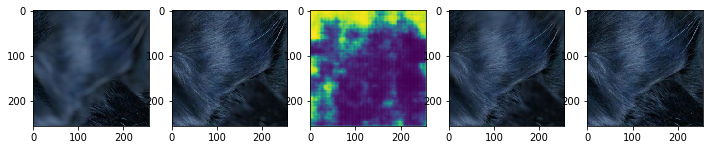

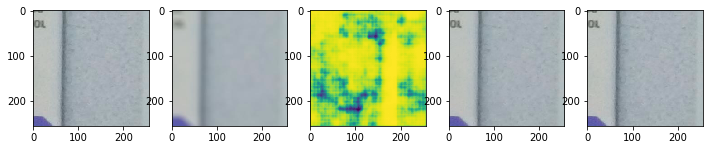

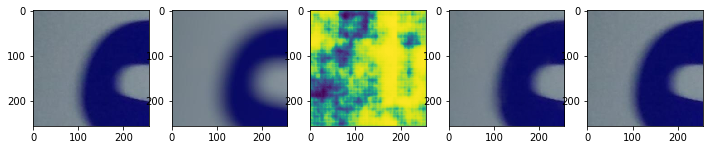

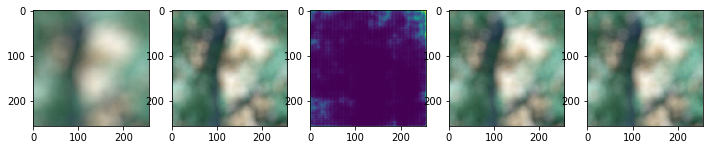

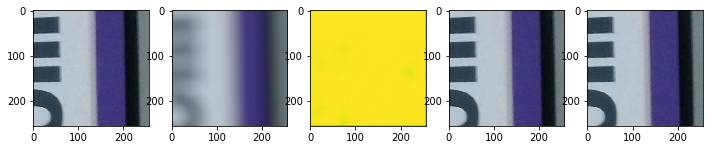

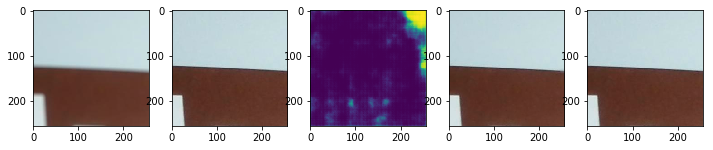

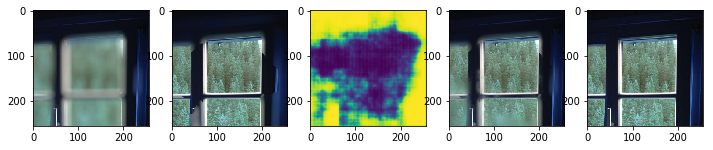

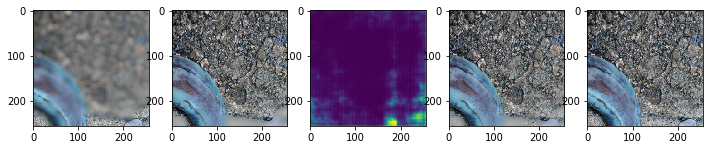

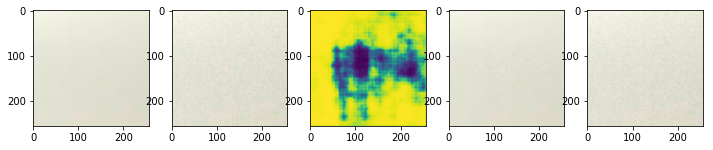

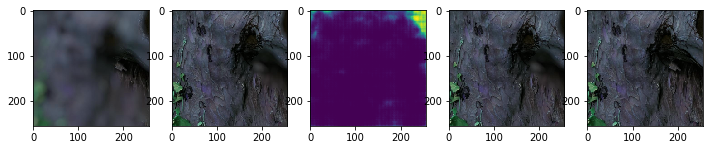

In [18]:
for imgIdx in range(10):
    fig=plt.figure(figsize=(12, 12))
    columns = 5
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(x_train1[imgIdx, :, :, :])
    fig.add_subplot(rows, columns, 2)
    plt.imshow(x_train2[imgIdx, :, :, :])
    fig.add_subplot(rows, columns, 3)
    plt.imshow((layer_output[imgIdx, :, :, 0]+1)/2)
    fig.add_subplot(rows, columns, 4)
    plt.imshow((prediction[imgIdx, :, :, :]+1)/2)
    fig.add_subplot(rows, columns, 5)
    plt.imshow(y_train[imgIdx, :, :, :])
    plt.show()    
# fig.savefig(dataPath+"results/struc_loss{:.2E}.png".format(lambda_tv))

In [19]:
# generator.save_weights('my_model_weights.h5')

# # # from keras.models import load_model
# # # model = load_model('my_model.h5')